In [3]:
import os
import gc
import cv2
import openslide
import numpy as np
import pandas as pd

from PIL import Image
from openslide.deepzoom import DeepZoomGenerator
from preprocessing import get_train_path, get_pos_path
from preprocessing import open_slide, create_tiles
from preprocessing import create_patches

In [20]:
slide_paths = {1: '/home/excelsiorcjh/D/dev/help/notebook/data/train/image/positive/Slide003.mrxs'}
mask_paths = {1: '/home/excelsiorcjh/D/dev/help/notebook/data/train/mask/positive/Slide003.png'}
# slide_path = '/home/excelsiorcjh/D/dev/help/notebook/data/train/image/negative/Slide001.mrxs'
# truth_path = '/home/excelsiorcjh/D/dev/help/notebook/data/train/mask/negative/Slide001.png'

In [21]:
def save_patches(samples,
                 slide_path,
                 truth_path,
                 patch_size=256,
                 is_training=True):
    
    slide_name = os.path.split(slide_path)[1].split('.')[0]

    slide = open_slide(slide_path)
    tiles = create_tiles(slide, tile_size=patch_size)

    start_x, start_y = 0, 0
    if 'pos' in slide_path:
        start_x = int(slide.properties.get('openslide.bounds-x', 0)) / patch_size
        start_y = int(slide.properties.get('openslide.bounds-y', 0)) / patch_size
        truth = open_slide(truth_path)
        truth_tiles = create_tiles(truth, tile_size=16)
        
#     samples = samples.sample(num_samples, random_state=42)  # shuffling
    num_tumor_dict = samples['is_tumor'].value_counts().to_dict()
    num_false = num_tumor_dict[True]
    num_true = num_tumor_dict[False]

    if num_true > 300:
        num_false, num_true = 300, 300
    elif num_true < 300:
        num_false = 300

    tumor_samples = samples.query('is_tumor == True').sample(num_true, random_state=42)
    false_samples = samples.query('is_tumor == False').sample(num_false, random_state=42)
    train_samples = tumor_samples.append(false_samples)
    
    tumor_samples = samples.query('is_tumor == True').sample(45)
    false_samples = samples.query('is_tumor == False').sample(45)
    val_samples = tumor_samples.append(false_samples)
    
    for idx, (y, x) in enumerate(train_samples['tile_loc'].values):
        img = tiles.get_tile(tiles.level_count-1, (x+start_x, y+start_y))
        if 'pos' in slide_path:
            mask_tile = truth_tiles.get_tile(truth_tiles.level_count-1, (x, y))
            mask_tile = (cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY) > 0).astype(int)
            if mask_tile[0][0] == 0:
                img.save('./tiles/train/neg/{}_neg_{}.png'.format(slide_name, idx))
            else:
                img.save('./tiles/train/pos/{}_pos_{}.png'.format(slide_name, idx))
                
    for idx, (y, x) in enumerate(val_samples['tile_loc'].values):
        img = tiles.get_tile(tiles.level_count-1, (x+start_x, y+start_y))
        if 'pos' in slide_path:
            mask_tile = truth_tiles.get_tile(truth_tiles.level_count-1, (x, y))
            mask_tile = (cv2.cvtColor(np.array(mask_tile), cv2.COLOR_RGB2GRAY) > 0).astype(int)
            if mask_tile[0][0] == 0:
                img.save('./tiles/val/neg/{}_neg_{}.png'.format(slide_name, idx))
            else:
                img.save('./tiles/val/pos/{}_pos_{}.png'.format(slide_name, idx))

In [22]:
for slide_path, mask_path, in zip(slide_paths.values(), mask_paths.values()):
    samples = create_patches(slide_path, mask_path)
    save_patches(samples, slide_path, mask_path)
    print('{} finished!!'.format(os.path.split(slide_path)))

('/home/excelsiorcjh/D/dev/help/notebook/data/train/image/positive', 'Slide003.mrxs') finished!!


In [7]:
import keras

from keras import layers, models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from model import create_model

Using TensorFlow backend.


In [8]:
train_dir = './tiles/train/'
val_dir = './tiles/val/'

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range =(0.65, 1.),
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256), 
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

Found 600 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [11]:
# train_x, train_y =  next(train_generator)

In [31]:
# import matplotlib.pyplot as plt

In [14]:
# from IPython.core.pylabtools import figsize
# figsize(14, 5)

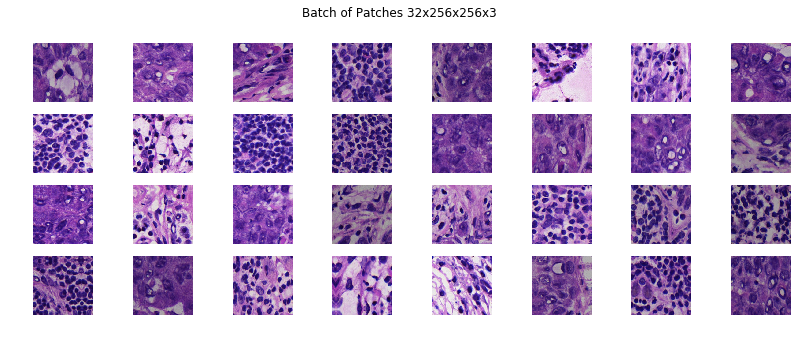

In [15]:
# f, axes = plt.subplots(4, 8);
# ax = axes.flatten()
# for i in range(0, train_x.shape[0]):
#     _ = ax[i].imshow(train_x[i]);
#     _ = ax[i].axis('off');
# f.suptitle('Batch of Patches 32x256x256x3');
    
# # f, axes = plt.subplots(5, 20, figsize=(20, 4));
# # ax = axes.flatten()    
# # for i in range(0, train_x.shape[0]):
# #     _ = ax[i].imshow(train_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
# #     _ = ax[i].axis('off');
# # f.suptitle('Batch of Truth Masks 32x256x256x1');

In [16]:
from keras.utils import to_categorical

In [24]:
def generator(gen):
    while 1:
        train_x, labels = next(gen)
        train_y = []
        for label in labels:
            if label == 0:
                train_y.append(np.zeros((256, 256)))
            else:
                train_y.append(np.ones((256, 256), dtype='float'))
        train_y = np.array(train_y)
        train_y = to_categorical(train_y, num_classes=2)
        yield train_x, train_y

In [25]:
train_gen = generator(train_generator)
val_gen = generator(validation_generator)

In [22]:
model = create_model()

In [33]:
batch_size = 64
n_epochs = 3
val_steps = 1
model.fit_generator(train_gen,
          steps_per_epoch=200, 
          epochs=n_epochs,
          validation_data=val_gen,
          validation_steps=val_steps,
          verbose=1)

Epoch 1/3
200/200 [==============================] - 96s 482ms/step - loss: 0.1773 - acc: 0.9310 - val_loss: 0.4954 - val_acc: 0.7182
Epoch 2/3
200/200 [==============================] - 96s 481ms/step - loss: 0.1557 - acc: 0.9407 - val_loss: 0.1137 - val_acc: 0.9577
Epoch 3/3
200/200 [==============================] - 95s 477ms/step - loss: 0.1380 - acc: 0.9473 - val_loss: 0.1053 - val_acc: 0.9615


In [34]:
# batch_size = 32
# n_epochs = 3
# val_steps = 45 // batch_size
# model.fit_generator(train_generator,
#           steps_per_epoch=200, 
#           epochs=n_epochs,
#           validation_data=validation_generator,
#           validation_steps=val_steps,
#           verbose=1)

## Predict

In [35]:
def test_generator(samples,
                   slide_path,
                   batch_size,
                   patch_size=256,
                   shuffle=True):
    
    slide = openslide.open_slide(slide_path)

    # tiles
    tiles = DeepZoomGenerator(slide, tile_size=patch_size, overlap=0, limit_bounds=False)

    num_samples = len(samples)
    while 1:
        if shuffle:
            samples = samples.sample(frac=1)  # shuffling

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]

            batch_tiles= []
            for slide_path, (y, x) in zip(batch_samples['slide_path'].values, 
                                          batch_samples['tile_loc'].values):
                img = tiles.get_tile(tiles.level_count-1, (x, y))             
                
                if img.size != (patch_size, patch_size):
                    img = Image.new('RGB', (patch_size, patch_size))
                    
                batch_tiles.append(np.array(img))
                
            # train_x
            test_x = np.array(batch_tiles) / 255.
            yield test_x

In [318]:
# slide_path = '/home/excelsiorcjh/D/dev/help/notebook/data/train/image/negative/Slide001.mrxs'
slide_path = '/home/excelsiorcjh/D/dev/help/notebook/data/test/Slide003.mrxs'
samples = create_patches(slide_path, 'test')

In [319]:
num_samples = len(samples)
if num_samples > 5000:
    num_samples = 3000

In [320]:
samples = samples.sample(num_samples, random_state=42)
samples.reset_index(drop=True, inplace=True)

test_gen = test_generator(samples, slide_path, batch_size)
test_steps = np.ceil(len(samples) / batch_size)

In [321]:
%%time
from scipy import stats

predicts = model.predict_generator(test_gen, 
                                   steps=test_steps)

preds = predicts[:, :, :, 1]
a = preds.reshape((1000, -1))
b = stats.mode(a)
b = b[0]
print(np.average(b))

0.9520332
CPU times: user 31.5 s, sys: 5.56 s, total: 37.1 s
Wall time: 25.7 s


In [288]:
np.average(b[::-1][:10])

0.9525488

In [23]:
slide_paths, mask_paths = get_pos_path()

In [24]:
len(slide_paths)

102

In [27]:
45 * 102 // 64

71